In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, MetaData, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
metadata = MetaData()
# reflect the tables
metadata.reflect(bind=engine)

In [6]:
# View all of the classes that automap found
Base = automap_base()

Base.prepare(engine, reflect=True)

print(Base.classes.keys())

['measurement', 'station']


C:\Users\Canj9\AppData\Local\Temp\ipykernel_6972\890096886.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
Session = sessionmaker(bind=engine)

session = Session()

# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


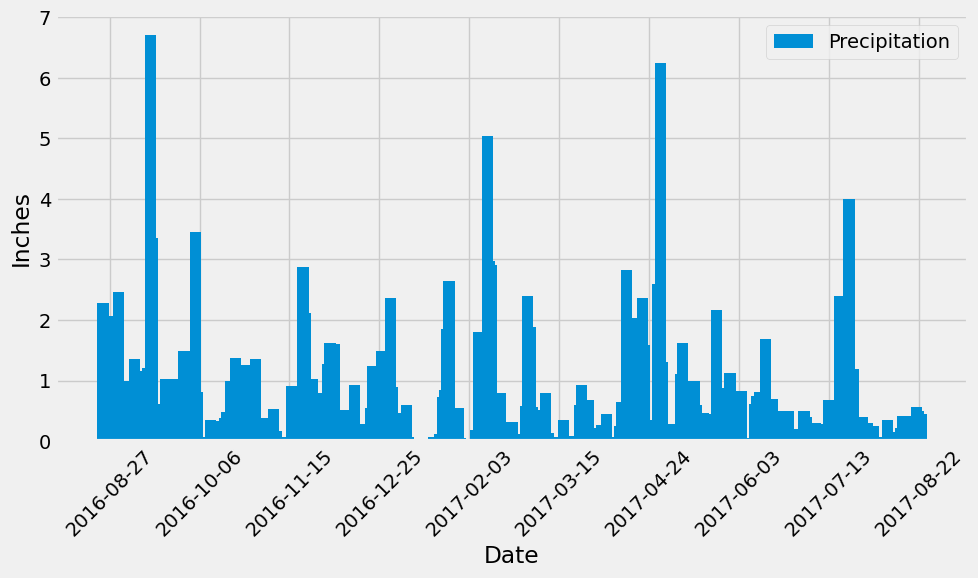

In [34]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
query_results = session.query(Measurement.date, Measurement.prcp)\
                        .filter(Measurement.date >= one_year_ago)\
                        .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(query_results, columns=['date', 'precipitation'])
df['date'] = pd.to_datetime(df['date'])

# Sort the dataframe by date
df.sort_values('date', inplace=True)
df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(df.index, df['precipitation'], width=5, label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))  # Adjust 12 to the desired number of ticks

plt.tight_layout()
plt.show()


In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['precipitation'].describe()
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(total_stations)

9


In [24]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                              .group_by(Measurement.station)\
                              .order_by(func.count(Measurement.station).desc())\
                              .all()
print("Most active stations:")
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Most active stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [25]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0] 

temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs))\
                           .filter(Measurement.station == most_active_station)\
                           .all()

lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f"Most active station: {most_active_station}")
print(f"Lowest temperature: {lowest_temp} °F")
print(f"Highest temperature: {highest_temp} °F")
print(f"Average temperature: {avg_temp:.2f} °F")

Most active station: USC00519281
Lowest temperature: 54.0 °F
Highest temperature: 85.0 °F
Average temperature: 71.66 °F


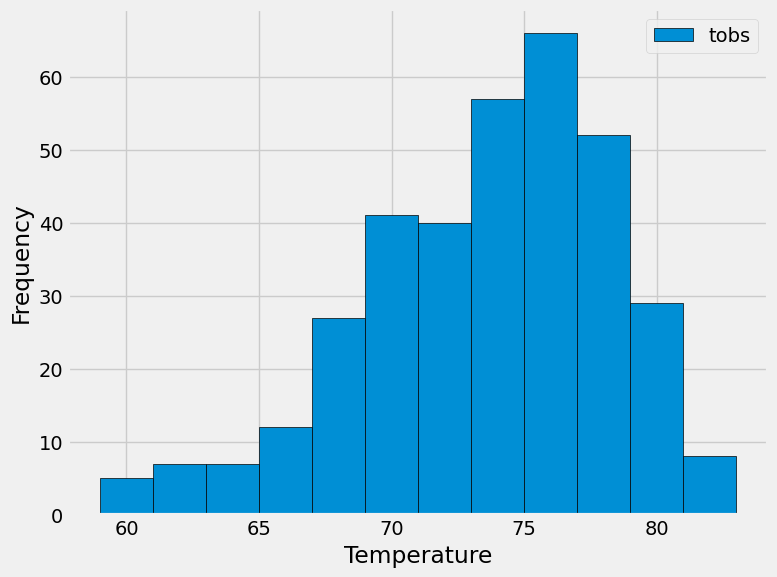

In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs)\
                          .filter(Measurement.station == most_active_station)\
                          .filter(Measurement.date >= one_year_ago)\
                          .all()

temperature_list = [temp[0] for temp in temperature_data]

plt.figure(figsize=(8, 6))
plt.hist(temperature_list, bins=12, edgecolor='black', label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [32]:
# Close Session
session.close()